# Package installs

In [1]:
%pip install pybullet gym[atari,box2d]

# Imports

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pybullet_envs
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image, ImageOps, ImageDraw
from collections import deque

import gym
from gym import error, spaces, utils, wrappers
%matplotlib inline

# Custom gym environment

In [0]:
class CityMap(gym.Env):
    metadata = {'render.modes': ['human', 'rgb_array']}
    reward_range = (-float('inf'), float('inf'))
    spec = None
    
    observation_window_size = 80
    # observation_window_size is the side length of the square surrounding the car
    # The car would see (observation_window_size/2) ahead and behind and (observation_window_size/2) to the left and right
    
    max_turn_radians = np.pi/36.0
    # pi/6 radians = 180/36 = 5 degrees
    # The car can turn 5 degrees to the left or right    
    
    distance_threshold_done = 30
    # Distance to target to reach before considering the episode done
    
    goal_circle_radius = int(distance_threshold_done/2)

    #Max steps before we call the episode done
    max_episode_steps = 10000
    
    def __init__(self, citymap, roadmask, car_image):
        self.action_space = spaces.Box(low = np.float64(-self.max_turn_radians), high = np.float64(self.max_turn_radians), shape = (1,) ) 
        # Action space is how many degrees to turn the car in radians
        
        self.observation_space = spaces.Box(low = 0, high = 255, shape = (self.observation_window_size, self.observation_window_size) ) 
        # All combinations of white and black pixels of observation_window_size x observation_window_size
        
        self.state = None
        
        self.citymap = citymap.copy()
        self.roadmask = roadmask.copy()
        self.car_image = car_image.copy()
        
        #Find size of the roadmask for reference later
        self.roadmask_size_x, self.roadmask_size_y = self.roadmask.getbbox()[2:4]
        
        # Pad the road mask image to allow for rotations
        # Amount of padding required = ( diagonal length of the observation window )/2
        self.padding_size = int(self.observation_window_size/np.sqrt(2))
        padding = ( self.padding_size, self.padding_size, self.padding_size, self.padding_size )
        self.roadmaskpadded = ImageOps.expand( self.roadmask, padding, fill = 255 ) # Pad and fill with sand
        
        #Set goal point
        self.goal_x = 1154
        self.goal_y = 158
        
        self.car_pos_x = 0
        self.car_pos_y = 0

        self.num_steps = 0
        
        self.reset()

    """
        Parameters:
        
        Returns:
            ( next_state, reward, done, info )
        
    """
    def step(self, action):

        # Things to compute
        # 1. Next position
        # 2. Screen grab from next position ( Next state )
        # 3. Reward on moving to next position
        # 4. Update number of steps taken
        # 5. Is the episode done
        # 6. Any info to pass on to the agent
        


        # 1. Next position
        # From (pos_x, pos_y) we move forward with 'speed' steps in the direction 'angle+action'
        # New angle of car
        self.car_angle = self.car_angle + action
        if(self.car_angle < 0):
            self.car_angle = (2*np.pi) + self.car_angle
        elif(self.car_angle > (2*np.pi)):
            self.car_angle = self.car_angle - (2*np.pi)
        
        # Car speed depends on whether we are riding on sand or not
        speed = 5 if self.roadmask.getpixel(( self.car_pos_x, self.car_pos_y )) == 0 else 2
        
        displacement_x = speed * np.sin( self.car_angle )
        displacement_y = -1 * speed * np.cos( self.car_angle )
        # Displacement y is negative since the top of the frame is y=0
        # Hence if the car is pointing upwards ( oriented at 0 degrees ) then the y values would decrease
        
        self.car_pos_x = self.car_pos_x + displacement_x
        self.car_pos_y = self.car_pos_y + displacement_y
        
        # Clip position to boundaries of the image
        self.car_pos_x = np.clip(self.car_pos_x, 0, self.roadmask_size_x-1) 
        self.car_pos_y = np.clip(self.car_pos_y, 0, self.roadmask_size_y-1)
        
        # 2. Screen grab from next position ( Next state )
        next_state = self._extract_current_frame()
        
        # 3. Reward on moving to next position
        
        new_distance_from_goal = np.sqrt( (self.car_pos_x - self.goal_x)**2 + (self.car_pos_y - self.goal_y)**2 )
        
        pixel_value_at_car_pos = self.roadmask.getpixel((self.car_pos_x, self.car_pos_y))
#         assert pixel_value_at_car_pos in [0,1], "Pixel values are not exactly 0 or 1")
        
        if( pixel_value_at_car_pos == 1 ):
            #Currently on sand
            # reward = -1
            reward = -100 * ((new_distance_from_goal+100)/1650) # 1650 is the length of the diagonal of the image
        elif( new_distance_from_goal > self.distance_from_goal ):
            # reward = -0.2
            reward = -10.2 * (new_distance_from_goal/1650)
        elif ( new_distance_from_goal == self.distance_from_goal ):
            # In one of the corners and driving into the corner
            reward = -100
        else:
            # new_distance_from_goal < self.distance_from_goal
            # reward = 0.1
            reward = 0.2 * ((1650-new_distance_from_goal)/1650)

        
        self.distance_from_goal = new_distance_from_goal

        # 4. Update number of steps taken

        self.num_steps += 1
        
        # 5. Is the episode done?
        
        if( new_distance_from_goal < self.distance_threshold_done  or self.num_steps == self.max_episode_steps ):
            # Either we have reached the target position or we have exceed the max steps for this episode
            done = 1
            self.reset()
            next_state = np.expand_dims( 
                np.expand_dims( 
                    np.zeros( self.observation_window_size**2 ).reshape((self.observation_window_size,self.observation_window_size) ),
                    axis = 0 
                ),
                axis = 0 )
        else:
            done = 0

        # 6. Any info to pass on to the agent

        # print(
        #     "x: "+ str(self.car_pos_x.round(0)) + 
        #     "; y: " + str(self.car_pos_y.round(0)) + 
        #     "; angle(deg): " + str(np.round(self.car_angle*180/np.pi),2) + 
        #     "; action: " + str(np.round(action*180/np.pi,2)) +
        #     "; reward: " + str(reward)
        #     )
        
        return next_state, reward, done, {}

    """
        Extracts the frame that the agent/car currently sees
        With respect to the frame extracted the car is always pointing upward
        Keeping the orientation fixed is key since else for the same scene( screen grab ), the car can be in different orientations 
        and hence should take different actions
        
        For example take the following case 
            Environment: A single straight road with the car in the middle on the road
            Goal: Left end of the road and outside the visibility of the agent
        
            The car can be oriented left or right and the goal can be to the left or right
            <<< NEED TO THINK OF A BETTER EXAMPLE >>>
            
        Parameters:
            None
        
        Returns:
            img - Numpy array of shape ( observation_window_size, observation_window_size )
    """
    def _extract_current_frame(self):
        # We know the current position of the car
        # Step 1: Extract a square of size observation_window_size*sqrt(2) surrounding the car ( Call this rough cut )
        # Step 2: Rotate the rough cut image around the center by angle of the car
        # Step 3: Extract a square of size observation_window_size around the center
        
        
        # Step 1: Extract a square of size observation_window_size*sqrt(2) surrounding the car ( Call this rough cut )
        # We need to use the padded version of the road mask here
        # Hence we add self.padding_size to the x,y position of the car
        bounding_box_rough_cut = ( self.car_pos_x, self.car_pos_y, self.car_pos_x+(2*self.padding_size), self.car_pos_y+(2*self.padding_size) )
        # print("Bounding box of rough cut: " +str(bounding_box_rough_cut))

        rough_cut = self.roadmaskpadded.crop(bounding_box_rough_cut)
        
        # Step 2: Rotate the rough cut image around the center by angle of the car
        
        rough_cut_rotated = rough_cut.rotate( self.car_angle * (180/np.pi) )
        # PIL's rotate function:
        #  - takes input in degrees ( 180 degrees = pi radians; x radians = x*(180/pi) degrees )
        #  - by default rotates around the center of the image
        #  - rotates anti-clockwise
        
        # Step 3: Extract a square of size observation_window_size around the center
        # Center of the rough cut image is ( rough_cut_size/2, rough_cut_size/2 )
        
        bounding_box_current_frame = ( 
            self.padding_size - (self.observation_window_size/2), 
            self.padding_size - (self.observation_window_size/2), 
            self.padding_size + (self.observation_window_size/2), 
            self.padding_size + (self.observation_window_size/2)
        )
        
        current_frame = rough_cut_rotated.crop(bounding_box_current_frame)

        return np.expand_dims( np.expand_dims( np.asarray(current_frame)/255, axis = 0 ), axis = 0 )
    
    def reset(self):
        #Randomly initialise the starting position and set velocity
        self.car_pos_x = np.random.randint( 0, self.roadmask_size_x )
        self.car_pos_y = np.random.randint( 0, self.roadmask_size_y )
        # Car position is measured with respect to the road mask ( without padding ). (0,0) is top left
        self.car_angle = np.random.default_rng().random() * np.pi * 2.0
        # Initial angle ranges from 0 to 2*pi
        # Angle measures rotation from vertical axis (i.e angle = 0 when car is heading upwards in the map)
        
        #Distance from goal
        self.distance_from_goal = np.sqrt( (self.car_pos_x - self.goal_x)**2 + (self.car_pos_y - self.goal_y)**2 )

        #Set num_steps to 0
        self.num_steps = 0
        
        return self._extract_current_frame()


    def render(self, mode='human', close=False):
        # self.viewer = rendering.SimpleImageViewer()
        #Build image of map with goal and car overlaid
        
        #Create a copy of the map
        map_copy = self.citymap.copy()
        
        #Draw a circle over the goal
        draw = ImageDraw.Draw(map_copy)
        draw.ellipse( 
            (self.goal_x - self.goal_circle_radius, 
             self.goal_y-self.goal_circle_radius, 
             self.goal_x+self.goal_circle_radius, 
             self.goal_y+self.goal_circle_radius
            ), 
            fill = 'red', 
            outline = 'red', 
            width = 1 
        )
        del(draw)
        
        # Create a copy of the car and rotate it to the currrent orientation according to the env state
        # Using 90 - curr_angle since the car image oriented horizontally while our angles are from the vertical
        car_image_copy = self.car_image.copy().rotate( 360 - (self.car_angle*180/np.pi), expand = True )
        car_size_x, car_size_y = car_image_copy.getbbox()[2:4] # The last 2 coordinates represent the size of the car
        
        #Overlay the car on the map ( copy )
        map_copy.paste( car_image_copy, box = ( int(self.car_pos_x - (car_size_x/2)), int(self.car_pos_y - (car_size_y/2)) ) )
        del(car_image_copy)
        del(car_size_x)
        del(car_size_y)        
        
        current_frame = Image.fromarray( self._extract_current_frame().squeeze(0).squeeze(0)*255 ).convert('RGB')
        
        if mode == 'rgb_array':
            # return np.asarray(current_frame)
            return np.asarray(map_copy)
#         elif mode == 'human':
#             if self.viewer is None:
#                 self.viewer = rendering.SimpleImageViewer()
# #             self.viewer.imshow(np.asarray(current_frame)*255)
#             self.viewer.imshow(np.asarray(map_copy))
#             return self.viewer.isopen
    
    def close(self):
        pass
        # if self.viewer is not None:
        #     self.viewer.close()
        #     print(self.viewer.isopen)
        #     self.viewer = None

# Model helpers

In [0]:
class ReplayBuffer(object):

  def __init__(self, max_size=1e6):
    self.storage = []
    self.max_size = max_size
    self.ptr = 0

  def add(self, transition):
    if len(self.storage) == self.max_size:
      self.storage[int(self.ptr)] = transition
      self.ptr = (self.ptr + 1) % self.max_size
    else:
      self.storage.append(transition)

  def sample(self, batch_size):
    sample_tuples = random.sample(self.storage, batch_size)
    batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = tuple(zip(*sample_tuples))
    return np.array(batch_states), batch_next_states, batch_actions, batch_rewards, batch_dones
    
def evaluate_policy(policy, env, eval_episodes=3):
  avg_reward = 0.
  for _ in range(eval_episodes):
    obs = env.reset()
    # print("Observatin shape from evaluate policy")
    # print(type(obs))
    # print(obs.shape)
    done = False
    # print("Entering while loop")
    while not done:
      action = policy.select_action(obs)
      obs, reward, done, _ = env.step(action)
      avg_reward += reward
  avg_reward /= eval_episodes
  print ("---------------------------------------")
  print ("Average Reward over the Evaluation Step: %f" % (avg_reward))
  print ("---------------------------------------")
  return avg_reward

# Model classes

In [0]:
"""
    Compute output size of convolution layer with given kernel size and stride
    Assumes no padding
"""
def conv2d_size_out(size, kernel_size = 3, stride = 2, padding = 1):
    return int((size - kernel_size + (2*padding))/stride) + 1

class Actor(nn.Module):
  
  def __init__(self, state_dim, action_dim, max_action):
    super(Actor, self).__init__()
    
    self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=2, padding = 1)
    self.bn1 = nn.BatchNorm2d(4)
    self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=2, padding = 1)
    self.bn2 = nn.BatchNorm2d(8)
    #self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding = 1)
    #self.bn3 = nn.BatchNorm2d(32)
    
    #conv3_output_size = conv2d_size_out(conv2d_size_out(conv2d_size_out(state_dim)))
    conv3_output_size = conv2d_size_out(conv2d_size_out(state_dim))
    linear_input_size = conv3_output_size * conv3_output_size * 8
    # print("Linear input size : ", linear_input_size)
    
    self.head = nn.Linear(linear_input_size, action_dim)
    self.max_action = max_action
    
  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    # x = F.relu(self.bn3(self.conv3(x)))
    # with torch.no_grad():
    #     print("Shape x after convolutions: " + str(x.shape))
    #     print("Flattened x shape: " + str(x.view(x.size(0), -1).shape))
#         print("Shape of output after FC layer")     
    
    return self.max_action * torch.tanh(self.head(x.view(x.size(0), -1)))
    
class Critic(nn.Module):

  def __init__(self, state_dim, action_dim, max_action):
    super(Critic, self).__init__()
    self.max_action = max_action
    
    # conv3_output_side_size = conv2d_size_out(conv2d_size_out(conv2d_size_out(state_dim)))
    # conv3_total_output_size = conv3_output_side_size * conv3_output_side_size * 32
    
    conv2_output_side_size = conv2d_size_out(conv2d_size_out(state_dim))
    conv2_total_output_size = conv2_output_side_size * conv2_output_side_size * 8
    
    
    # Defining the first Critic neural network
    self.critic1_conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=2, padding = 1)
    self.critic1_bn1 = nn.BatchNorm2d(4)
    self.critic1_conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=2, padding = 1)
    self.critic1_bn2 = nn.BatchNorm2d(8)
    # self.critic1_conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding = 1)
    # self.critic1_bn3 = nn.BatchNorm2d(32) 
    self.critic1_head = nn.Linear(conv2_total_output_size+1, 1)
    # Critic gives out only 1 value hence the output dimension is one
    # Critic also takes action as input which is a scalar, hence adding 1 to linear_input_size
    
    # Defining the second Critic neural network
    self.critic2_conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=2, padding = 1)
    self.critic2_bn1 = nn.BatchNorm2d(4)
    self.critic2_conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=2, padding = 1)
    self.critic2_bn2 = nn.BatchNorm2d(8)
    # self.critic2_conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding = 1)
    # self.critic2_bn3 = nn.BatchNorm2d(32)
    self.critic2_head = nn.Linear(conv2_total_output_size+1, 1)
    # Critic gives out only 1 value hence the output dimension is one
    # Critic also takes action as input which is a scalar, hence adding 1 to linear_input_size

  def forward(self, x, u):
    ###############
    ## Critic 1
    ###############
    # Pass through convolutional layers
    x1 = F.relu(self.critic1_bn1(self.critic1_conv1(x)))
    x1 = F.relu(self.critic1_bn2(self.critic1_conv2(x1)))
    # x1 = F.relu(self.critic1_bn3(self.critic1_conv3(x1)))
    x1 = x1.view(x1.size(0), -1)
 
    #Concatenate action with the output of the convolutional layers
    x1 = torch.cat([x1, u], 1)
    
    #Pass through FC layer
    x1 = self.critic1_head(x1)

    ###############
    # Critic 2
    ###############
    
    #Pass through convolutional layers
    x2 = F.relu(self.critic2_bn1(self.critic2_conv1(x)))
    x2 = F.relu(self.critic2_bn2(self.critic2_conv2(x2)))
    # x2 = F.relu(self.critic2_bn3(self.critic2_conv3(x2)))
    x2 = x2.view(x1.size(0), -1)
 
    #Concatenate action with the output of the convolutional layers
    x2 = torch.cat([x2, u], 1)
    
    #Pass through FC layer
    x2 = self.critic2_head(x2)
    
    return x1, x2

  def Q1(self, x, u):   
    ###############
    ## Critic 1
    ###############
    # Pass through convolutional layers
    x1 = F.relu(self.critic1_bn1(self.critic1_conv1(x)))
    x1 = F.relu(self.critic1_bn2(self.critic1_conv2(x1)))
    # x1 = F.relu(self.critic1_bn3(self.critic1_conv3(x1)))
    x1 = x1.view(x1.size(0), -1)
 
    #Concatenate action with the output of the convolutional layers
    x1 = torch.cat([x1, u], 1)
    
    #Pass through FC layer
    x1 = self.critic1_head(x1)
    
    return x1


class TD3(object):
  
  def __init__(self, state_dim, action_dim, max_action, device):
    self.device = device
    self.actor = Actor(state_dim, action_dim, max_action).to(self.device)
    self.actor_target = Actor(state_dim, action_dim, max_action).to(self.device)
    self.actor_target.load_state_dict(self.actor.state_dict())
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters())
    self.critic = Critic(state_dim, action_dim, max_action).to(self.device)
    self.critic_target = Critic(state_dim, action_dim, max_action).to(self.device)
    self.critic_target.load_state_dict(self.critic.state_dict())
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters())
    self.max_action = max_action

  def select_action(self, state):
    state = torch.Tensor(state).to(self.device)
    return self.actor(state).cpu().data.numpy().flatten()[0]

  def train(self, replay_buffer, iterations, batch_size=100, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):
    
    print( "Replay buffer size at beginning of call to train: " + str(len(replay_buffer.storage)) )
    actor_conv1_frozen = self.actor.conv1.weight.data.clone().detach()
    actor_conv2_frozen = self.actor.conv2.weight.data.clone().detach()
    actor_head_frozen = self.actor.head.weight.data.clone().detach()

    for it in range(iterations):
      if(it%1000 == 0):
        print("Training iteration local: " + str(it))
      # Step 4: We sample a batch of transitions (s, s’, a, r) from the memory
      batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = replay_buffer.sample(batch_size)
      
      # Each element obtained from the replay_buffer is a np array
      # Each element of the batch_states, batch_next_states is of the shape (1,1,size,size)
      # Batch_states and batch_next_states have shapes (batch_size,1,1,size,size)
      # What we want to feed to the conv networks is (batch_size, 1, size, size)
      # Hence we squeeze out the first dimension ( zero'th dimension of size batch_size is intact )

      # Each element of batch_rewards, batch_actions, batch_dones is a scalar
      # We need to give a column vector to pytorch to compute losses
      # Hence scalars go through a reshape(-1,1) ( eg: [1,2,3] to [[1],[2],[3]] )

      state = torch.Tensor(batch_states).squeeze(1).to(self.device)
      next_state = torch.Tensor(batch_next_states).squeeze(1).to(self.device) 
      action = torch.Tensor(batch_actions).view(-1,1).to(self.device) #Convert row vector to column vector eg: [1,2,3] to [[1],[2],[3]]
      reward = torch.Tensor(batch_rewards).view(-1,1).to(self.device) #Convert row vector to column vector eg: [1,2,3] to [[1],[2],[3]]
      done = torch.Tensor(batch_dones).view(-1,1).to(self.device) #Convert row vector to column vector eg: [1,2,3] to [[1],[2],[3]]
      
      # Step 5: From the next state s’, the Actor target plays the next action a’
      next_action = self.actor_target(next_state)
      
      # Step 6: We add Gaussian noise to this next action a’ and we clamp it in a range of values supported by the environment
      # noise = torch.Tensor(batch_actions).data.normal_(0, policy_noise).to(self.device)
      # noise = noise.clamp(-noise_clip, noise_clip)
      # noise = noise.reshape(-1,1)
      noise_distribution = torch.distributions.normal.Normal(0, policy_noise)
      noise = noise_distribution.sample(torch.Size([batch_size])).clamp(-noise_clip,noise_clip).view(-1,1).to(self.device)
      next_action = (next_action + noise).clamp(-self.max_action, self.max_action)
      
      # print("Action shape: " + str(action.shape))
      # print("Next action shape: " + str(next_action.shape))
        
      # Step 7: The two Critic targets take each the couple (s’, a’) as input and return two Q-values Qt1(s’,a’) and Qt2(s’,a’) as outputs
      target_Q1, target_Q2 = self.critic_target(next_state, next_action)
      
      # Step 8: We keep the minimum of these two Q-values: min(Qt1, Qt2)
      target_Q = torch.min(target_Q1, target_Q2)
      
      # Step 9: We get the final target of the two Critic models, which is: Qt = r + γ * min(Qt1, Qt2), where γ is the discount factor
      target_Q = reward + ((1 - done) * discount * target_Q).detach()
      
      # Step 10: The two Critic models take each the couple (s, a) as input and return two Q-values Q1(s,a) and Q2(s,a) as outputs
      current_Q1, current_Q2 = self.critic(state, action)
      
#       print("Current Q1: ", current_Q1)
#       print("Current Q2: ", current_Q2)
#       print("Target Q: ", target_Q)

#       exit(0)
    
      # Step 11: We compute the loss coming from the two Critic models: Critic Loss = MSE_Loss(Q1(s,a), Qt) + MSE_Loss(Q2(s,a), Qt)
      critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)
      
      # Step 12: We backpropagate this Critic loss and update the parameters of the two Critic models with a SGD optimizer
      self.critic_optimizer.zero_grad()
      critic_loss.backward()
      self.critic_optimizer.step()
      
      # Step 13: Once every two iterations, we update our Actor model by performing gradient ascent on the output of the first Critic model
      if it % policy_freq == 0:        

        actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
        # print("Actor loss: " + str(actor_loss))

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()        
        
        # Step 14: Still once every two iterations, we update the weights of the Actor target by polyak averaging
        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        
        # Step 15: Still once every two iterations, we update the weights of the Critic target by polyak averaging
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
    
    #Compute change in weights after the training iterations
    actor_conv1_total_change = torch.sum( (torch.abs(self.actor.conv1.weight.data - actor_conv1_frozen) ) ).detach().cpu().numpy().flatten()[0]
    actor_conv2_total_change = torch.sum( (torch.abs(self.actor.conv2.weight.data - actor_conv2_frozen) ) ).detach().cpu().numpy().flatten()[0]
    actor_head_total_change = torch.sum( (torch.abs(self.actor.head.weight.data - actor_head_frozen) ) ).detach().cpu().numpy().flatten()[0]

    print("Actor Conv 1 total change: ", actor_conv1_total_change )
    print("Actor Conv 2 total change: ", actor_conv2_total_change )
    print("Actor head total change: ", actor_head_total_change )
  
  # Making a save method to save a trained model
  def save(self, filename, directory):
    torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
    torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))
  
  # Making a load method to load a pre-trained model
  def load(self, filename, directory):
    self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
    self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

# Generic helper functions

In [0]:
def mkdir(base, name):
    path = os.path.join(base, name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path

# Env declaration and variable setup

In [7]:
# Selecting the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Setting params
env_name = "CityMap"
seed = 0 # Random seed number
#TODO: Change start_timestamp to 1e4 again
start_timesteps = 1e4 # Number of iterations/timesteps before which the model randomly chooses an action, and after which it starts to use the policy network
eval_freq = 5e4 # How often the evaluation step is performed (after how many timesteps)
max_timesteps = 5e5 # Total number of iterations/timesteps
save_models = True # Boolean checker whether or not to save the pre-trained model
expl_noise = 0 #0.1 # Exploration noise - STD value of exploration Gaussian noise
batch_size = 100 # Size of the batch
discount = 0.99 # Discount factor gamma, used in the calculation of the total discounted reward
tau = 0.005 # Target network update rate
policy_noise = 0.2 # STD of Gaussian noise added to the actions for the exploration purposes
noise_clip = 0.5 # Maximum value of the Gaussian noise added to the actions (policy)
policy_freq = 2 # Number of iterations to wait before the policy network (Actor model) is updated
train_iterations = 1000 # Number of iterations to run the training cycle for each time an episide is over


#File name for actor and critic model saved files
file_name = "%s_%s_%s" % ("TD3", env_name, str(seed))
print ("---------------------------------------")
print ("Settings: %s" % (file_name))
print ("---------------------------------------")

#Create folder to save trained models
if not os.path.exists("./results"):
  os.makedirs("./results")
if save_models and not os.path.exists("./pytorch_models"):
  os.makedirs("./pytorch_models")

#Create the environment
citymap = Image.open("MASK1.png")
roadmask = Image.open("MASK1.png").convert('L')
car_image = Image.open("car_upright.png")
car_image_width, car_image_height = car_image.getbbox()[2:4]
car_image_resized = car_image.resize( (int(car_image_width/2), int(car_image_height/2)) )

work_dir = mkdir('exp', 'brs')
monitor_dir = mkdir(work_dir, 'monitor')

env = CityMap(citymap, roadmask, car_image_resized)
# env = wrappers.Monitor(env, monitor_dir, force = True, video_callable=lambda episode_id: True)
# env._max_episode_steps = 200
# print(env.reset())

# Set seeds and get get info to initiate classes
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
state_dim = env.observation_window_size
action_dim = 1
max_action = env.max_turn_radians

#Create the policy network
policy = TD3(state_dim, action_dim, max_action, device)

#Create the experience replay buffer
replay_buffer = ReplayBuffer()

#Initialise variables
total_timesteps = 0
timesteps_since_eval = 0
episode_num = 0
episode_timesteps = 1e3
done = True
t0 = time.time()

---------------------------------------
Settings: TD3_CityMap_0
---------------------------------------


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [8]:
%%time
#List for storing model evaluations
evaluations = [evaluate_policy(policy, env)]
# evaluations = [1]
evaluation_timesteps = [0]

---------------------------------------
Average Reward over the Evaluation Step: -24542.264158
---------------------------------------


In [9]:
device

device(type='cuda')

# Training

In [10]:
#Training
max_timesteps = 500000
# We start the main loop over 500,000 timesteps
while total_timesteps < max_timesteps:
  
  # print("Timesteps - total: " + str(total_timesteps) + "; done: " + str(done) ) 
  # If the episode is done
  if done:

    # Complete the recording
    # env.stats_recorder.save_complete()
    # env.stats_recorder.done = True

    # If we are not at the very beginning, we start the training process of the model
    if total_timesteps != 0:
      print("Total Timesteps: {} Episode Num: {} Reward: {}".format(total_timesteps, episode_num, episode_reward))
      policy.train(replay_buffer, train_iterations, batch_size, discount, tau, policy_noise, noise_clip, policy_freq)

    # We evaluate the episode and we save the policy
    if timesteps_since_eval >= eval_freq:
      timesteps_since_eval %= eval_freq
      evaluations.append(evaluate_policy(policy, env))
      evaluation_timesteps.append(total_timesteps)
      policy.save(file_name, directory="./pytorch_models")
      np.save("./results/%s" % (file_name), evaluations)
    
    # When the training step is done, we reset the state of the environment
    obs = env.reset()
    
    # Set the Done to False
    done = False
    
    # Set rewards and episode timesteps to zero
    episode_reward = 0
    episode_timesteps = 0
    episode_num += 1
  
  # Before 10000 timesteps, we play random actions
  if total_timesteps < start_timesteps:
    action = env.action_space.sample()[0]
  else: # After 10000 timesteps, we switch to the model
    action = policy.select_action(obs)
    # If the explore_noise parameter is not 0, we add noise to the action and we clip it
    if expl_noise != 0:
      action = (action + np.random.normal(0, expl_noise, size=env.action_space.shape[0])).clip(env.action_space.low, env.action_space.high)
  
  # The agent performs the action in the environment, then reaches the next state and receives the reward
  new_obs, reward, done, _ = env.step(action)

  # We check if the episode is done
  done_bool = 1 if episode_timesteps + 1 == env.max_episode_steps else float(done)
  done = bool(done_bool)

  # if(episode_timesteps == 199):
  #   print("Reached 199 episode length")
  #   print("done: "  +str(done))

  # We increase the total reward
  episode_reward += reward
  
  # We store the new transition into the Experience Replay memory (ReplayBuffer)
  replay_buffer.add((obs, new_obs, action, reward, done_bool))

  # We update the state, the episode timestep, the total timesteps, and the timesteps since the evaluation of the policy
  obs = new_obs
  episode_timesteps += 1
  total_timesteps += 1
  timesteps_since_eval += 1

env.close()
# Complete the recording
# env.stats_recorder.save_complete()
# env.stats_recorder.done = True

# We add the last policy evaluation to our list of evaluations and we save our model
evaluations.append(evaluate_policy(policy, env))
evaluation_timesteps.append(total_timesteps)

if save_models: policy.save("%s" % (file_name), directory="./pytorch_models")
np.save("./results/%s" % (file_name), evaluations)

Total Timesteps: 2657 Episode Num: 1 Reward: -54067.992003320374
Replay buffer size at beginning of call to train: 2657
Training iteration local: 0
Actor Conv 1 total change:  0.33088517
Actor Conv 2 total change:  2.0929341
Actor head total change:  27.046658
Total Timesteps: 12657 Episode Num: 2 Reward: -288475.492304047
Replay buffer size at beginning of call to train: 12657
Training iteration local: 0
Actor Conv 1 total change:  0.13997826
Actor Conv 2 total change:  1.2231523
Actor head total change:  1.3359303
---------------------------------------
Average Reward over the Evaluation Step: -14090.997877
---------------------------------------
Total Timesteps: 22657 Episode Num: 3 Reward: -17962.28579892931
Replay buffer size at beginning of call to train: 22657
Training iteration local: 0
Actor Conv 1 total change:  0.0014882397
Actor Conv 2 total change:  0.0150577165
Actor head total change:  0.016847823
---------------------------------------
Average Reward over the Evaluation

# Plot evaluation score over time

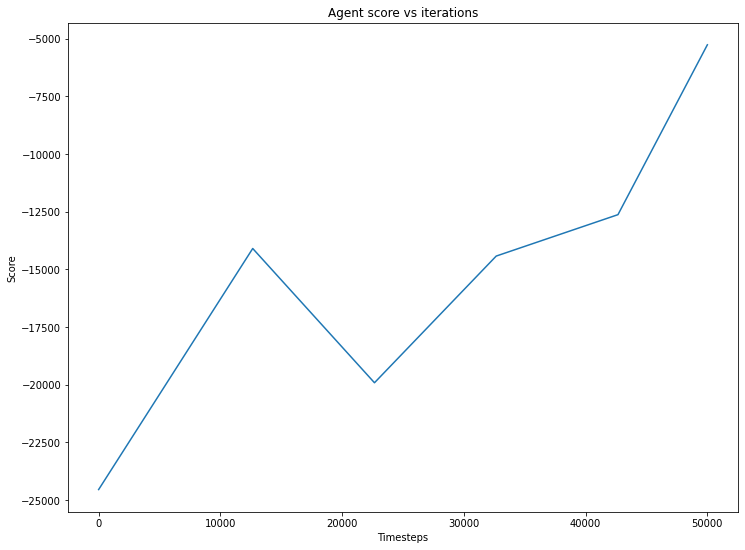

In [11]:
fig, ax = plt.subplots(1,1, figsize = (12,9))
ax.plot( evaluation_timesteps, evaluations )
ax.set_ylabel('Score')
ax.set_xlabel('Timesteps')
ax.set_title('Agent score vs iterations');

# Inference

In [15]:
policy_inference = TD3(state_dim, action_dim, max_action, device)
policy_inference.load(file_name, './pytorch_models/')

env_inference = CityMap(citymap, roadmask, car_image_resized)
env_inference = wrappers.Monitor(env_inference, monitor_dir, force = True, video_callable=lambda episode_id: True)

avg_reward_inference = evaluate_policy(policy_inference, env_inference, eval_episodes=3)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
Average Reward over the Evaluation Step: -12143.621939
---------------------------------------


In [16]:
avg_reward_inference

-12143.621938766628